In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from algo123 import *

import warnings
warnings.filterwarnings("ignore")

# show float in two decimal form
plt.style.use('ggplot')
pd.set_option('display.float_format',lambda x : '%.2f' % x)

ModuleNotFoundError: No module named 'algo123'

In [ ]:
VIC = pd.read_csv("../../data/vic.csv")
VIC['time'] = pd.to_datetime(VIC['time'])


In [ ]:
vic_train = VIC[VIC['time'] <= "2020-12-31 23:30:00"]
vic_cv = VIC[(VIC['time'] >= "2021-01-01 00:00:00") & (VIC['time'] <= "2021-06-30 23:30:00")].reset_index(drop=True)
vic_test = VIC[(VIC['time'] >= "2021-07-01 00:00:00") & (VIC['time'] <= "2021-08-11 23:30:00")].reset_index(drop=True)
vic_test

In [ ]:
vic_train

In [3]:
vic = pd.read_csv("../../data/vic_train.csv")
vic['raw_power'] = 0
vic['closing_capacity'] = 0
vic['market_dispatch'] = 0
vic['market_revenue'] = '-'
vic['charge_forecast'] = 0
vic['discharge_forecast'] = 0
vic = vic.loc[1:].reset_index(drop=True)
vic.head()

,time,spot_price,inter_gen,demand,period,raw_power,closing_capacity,market_dispatch,market_revenue,charge_forecast,discharge_forecast
0,2018-01-01 00:30:00,92.46,131.68,4398,2,0,0,0,-,0,0
1,2018-01-01 01:00:00,87.62,119.98,4238,3,0,0,0,-,0,0
2,2018-01-01 01:30:00,73.08,123.86,4112,4,0,0,0,-,0,0
3,2018-01-01 02:00:00,70.18,132.72,3956,5,0,0,0,-,0,0
4,2018-01-01 02:30:00,67.43,120.73,3833,6,0,0,0,-,0,0


In [21]:
def quantile_exc(ser, q):
    ser_sorted = ser.sort_values()
    rank = q * (len(ser) + 1) - 1
    assert rank > 0, 'quantile is too small'
    rank_l = int(rank)
    return ser_sorted.iat[rank_l] + (ser_sorted.iat[rank_l + 1] - 
                                     ser_sorted.iat[rank_l]) * (rank - rank_l)


def isCharge(future_price_period, current_price, quantile):
    future_price = quantile_exc(future_price_period, quantile)
    if (current_price < future_price):
        return 1
    return 0

def isDischarge(future_price_period, current_price, quantile):
    future_price = quantile_exc(future_price_period, quantile)
    if (current_price < future_price):
        return 0
    return 1

In [22]:
charge_period = 10
discharge_period = 10
charge_quantile = 0.25
discharge_quantile = 0.75

for index, row in vic.iterrows():
    spot_price = row['spot_price']
    
    if index == 0:
        opening_capacity = 0
    else:
        opening_capacity = vic['closing_capacity'][index-1]
    
    # cal forecast charge 
    if index < len(vic)-1-charge_period:
        charge_price_period = vic['spot_price'][index+1: index+charge_period+1]
    else: 
        charge_price_period = vic['spot_price'][index+1: len(vic)]
    
    charge_forecast = isCharge(charge_price_period, spot_price, charge_quantile)
    vic['charge_forecast'][index] = charge_forecast
    
    # cal forecast discharge period
    if index < len(vic)-1-discharge_period:
        discharge_price_period = vic['spot_price'][index+1: index+discharge_period+1]
    else: 
        discharge_price_period = vic['spot_price'][index+1: len(vic)]
    
    discharge_forecast = isDischarge(discharge_price_period, spot_price, discharge_quantile)
    vic['discharge_forecast'][index] = discharge_forecast
    
    raw_power = calc_a3_raw_power(charge_forecast, discharge_forecast, opening_capacity)
    market_dispatch = calc_market_dispatch(raw_power)
    closing_capacity = calc_closing_capacity(market_dispatch, opening_capacity)
    market_revenue = calc_market_revenue(market_dispatch, spot_price)
    vic['raw_power'][index] = raw_power
    vic['market_dispatch'][index] = market_dispatch
    vic['closing_capacity'][index] = closing_capacity
    vic['market_revenue'][index] = market_revenue
    
    if index ==210:
        break

In [23]:
vic.loc[0:50]

,time,spot_price,inter_gen,demand,period,raw_power,closing_capacity,market_dispatch,market_revenue,charge_forecast,discharge_forecast
0,2018-01-01 00:30:00,92.46,131.68,4398,2,0,0,0,0.00,0,1
1,2018-01-01 01:00:00,87.62,119.98,4238,3,0,0,0,0.00,0,1
2,2018-01-01 01:30:00,73.08,123.86,4112,4,0,0,0,0.00,0,1
3,2018-01-01 02:00:00,70.18,132.72,3956,5,0,0,0,0.00,0,1
4,2018-01-01 02:30:00,67.43,120.73,3833,6,0,0,0,0.00,0,1
5,2018-01-01 03:00:00,66.31,128.69,3749,7,0,0,0,0.00,0,0
6,2018-01-01 03:30:00,67.72,122.97,3702,8,0,0,0,0.00,0,1
7,2018-01-01 04:00:00,65.50,116.66,3688,9,0,0,0,0.00,0,0
8,2018-01-01 04:30:00,64.50,125.17,3700,10,0,0,0,0.00,0,0
9,2018-01-01 05:00:00,65.41,112.73,3701,11,0,0,0,0.00,0,0


In [17]:
np.quantile([1,2,3,4,5,6,7,8,9], 0.01)

1.08

In [11]:
np.quantile([1,3,2], 0.25)

1.5

In [5]:
period_fre = vic.groupby('period')['spot_price'].sum()

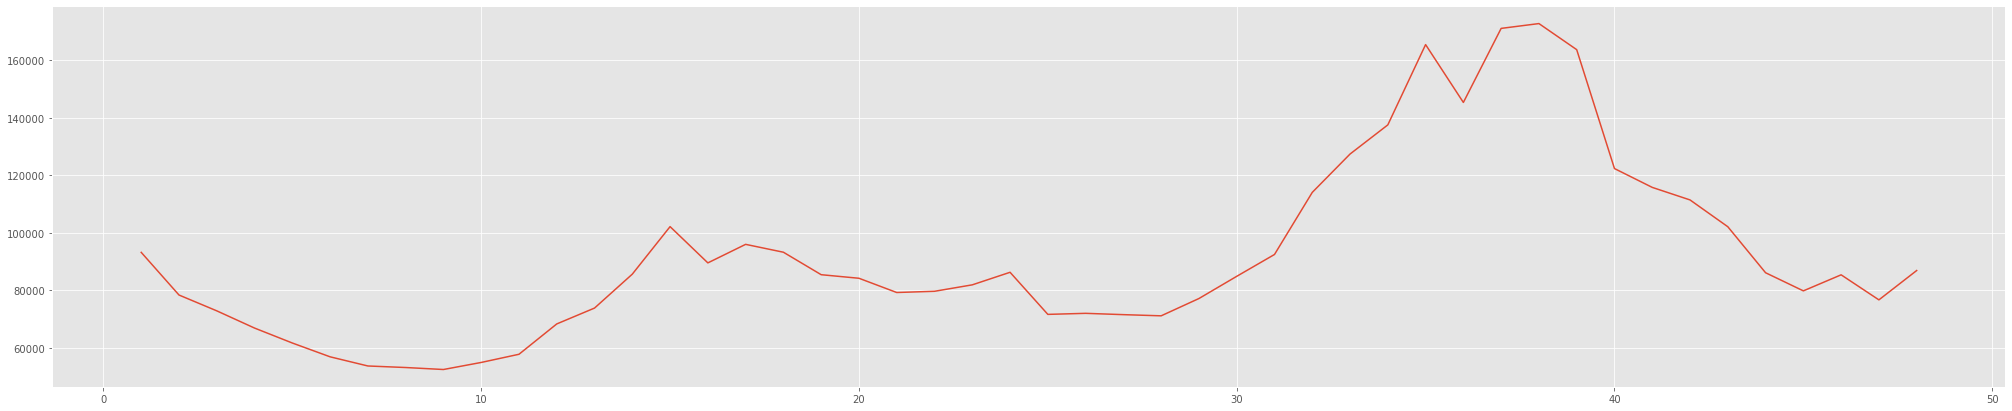

In [10]:
plt.figure(figsize=(35,7))

plt.plot(period_fre)
plt.xticks(data.period, fontsize=20)

In [13]:
df = pd.DataFrame({"one": [1.0, 2.0, 3.0, 4.0], "two": [4.0, 3.0, 2.0, 1.0]})
df

,one,two
0,1.00,4.00
1,2.00,3.00
2,3.00,2.00
3,4.00,1.00


## Update

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

from algo_sample import *
from algo_tom import *
from algo_utils import *
# import talib

# show float in two decimal form
plt.style.use('ggplot')
pd.set_option('display.float_format',lambda x : '%.2f' % x)

ModuleNotFoundError: No module named 'algo_sample'

In [2]:
vic = pd.read_csv("../../data/vic_train.csv")
vic_cv = pd.read_csv("../../data/vic_cv.csv")
vic_test = pd.read_csv("../../data/vic_test.csv")
vic = vic.loc[1:].reset_index(drop=True)
vic['time'] = vic['time'].astype('datetime64[ns]')
vic['year'] = vic['time'].dt.year
vic_test['time'] = vic_test['time'].astype('datetime64[ns]')
vic_test['year'] = vic_test['time'].dt.year
vic_cv['time'] = vic_cv['time'].astype('datetime64[ns]')
vic_cv['year'] = vic_cv['time'].dt.year
vic.head()

,time,spot_price,inter_gen,demand,period,year
0,2018-01-01 00:30:00,92.46,131.68,4398,2,2018
1,2018-01-01 01:00:00,87.62,119.98,4238,3,2018
2,2018-01-01 01:30:00,73.08,123.86,4112,4,2018
3,2018-01-01 02:00:00,70.18,132.72,3956,5,2018
4,2018-01-01 02:30:00,67.43,120.73,3833,6,2018


### find best lower and upper percentile

In [7]:
low_pctl_range = np.arange(0,0.5, 0.05)
upper_pctl_range = np.arange(0.55, 1, 0.05)
df = vic.copy(deep=False)[['time', 'spot_price', 'period', 'year']]

max_rev = 0
max_idx = {'low':0, 'upper': 0}
for i in range(len(low_pctl_range)):
    low_pctl = low_pctl_range[i]
    
    for j in range(len(upper_pctl_range)):
        upper_pctl = upper_pctl_range[j]
        
        cur_model = compute_algo_3(vic, method =2, window=12, lower_pctl=low_pctl, upper_pctl=upper_pctl)
        cur_rev = cur_model.market_revenue.sum()
        
        if cur_rev > max_rev:
            max_rev = cur_rev
            max_idx['low'] = low_pctl
            max_idx['upper'] = upper_pctl
        

print('max rev: ', max_rev)
print('max value:', max_idx, '\n')


max rev:  103482633
max value: {'low': 0.35000000000000003, 'upper': 0.7500000000000002} 



In [10]:
cur_model = compute_algo_3(vic, method =2, window=12, lower_pctl=0.35, upper_pctl=0.75)
cur_model.market_revenue.sum()
        

103482633

In [3]:
def filter_forecast_2(spot_price, forecast):
    """
    Notes: Select n smallest/higest spot price to charge/discharge
    ----------
    Parameters
    ----------
    spot_price  : Spot price series
    forecast    : forecast series
    
    Returns
    -------
    forecast    : forecast series
    """
    df = pd.DataFrame({'spot_price': spot_price, 'forecast': forecast})
    dict_forecast = {'-1': [], '1': []}

    columns = list(df.columns)
    spot_price_idx = columns.index('spot_price')
    forecast_idx = columns.index('forecast')

    # Convert to numpy array for faster speed
    arr = df.to_numpy()
    for i in range(len(arr)):
        arr_curr = arr[i]
        spot_price_curr = arr_curr[spot_price_idx]
        forecast_curr = arr_curr[forecast_idx]
        if forecast_curr == -1:
            
            if (len(dict_forecast['1']) == 4) & (len(dict_forecast['-1']) == 5):
                dict_forecast['1'] = [] # clear 1 dict
                dict_forecast['-1'] = [] # clear -1 dict

            elif (len(dict_forecast['1']) > len(dict_forecast['-1'])) & len(dict_forecast['-1']) >0:
                while len(dict_forecast['1']) > len(dict_forecast['-1']):
                    min_idx = np.argmin([item[1] for item in dict_forecast['1']]) # choose the lowest price row
                    idx = dict_forecast['1'][min_idx][0] # get index of the lowest price row
                    arr[idx][forecast_idx] = 0 # set the lowest price row forecast value to 0
                    dict_forecast['1'].pop(min_idx) # remove the lowest price row from dict
                dict_forecast['1'] = [] # clear 1 dict
                dict_forecast['-1'] = [] # clear -1 dict
        
            elif (len(dict_forecast['1']) >0) & (len(dict_forecast['1']) <= len(dict_forecast['-1'])):
                for j in range(len(dict_forecast['1'])):
                    dict_forecast['-1'].pop(0)
                dict_forecast['1'] = [] # clear 1 dict
        
        
            dict_forecast['-1'].append([i, spot_price_curr])
                        
                
        elif forecast_curr == 1: # if forecast value if 1
  
            dict_forecast['1'].append([i, spot_price_curr]) # add current row to dict
          
    # replace df columns with np array
    df[:] = arr
    
    forecast = df.forecast
    
    return forecast

### test train

In [4]:
# Algo Test train (with forecast filtered 1)
df1 = vic.copy(deep=False)[['time', 'spot_price', 'period', 'year']]
df1 = calc_forecast(df1, method =2, window=12, lower_pctl=0.35, upper_pctl=0.75)
df1['forecast'] = filter_forecast(df1.spot_price, df1.forecast)
# df['forecast'] = filter_forecast_2(df.spot_price, df.forecast)
df1 = compute_algo(df1)
print('=== Algorithm Test train 1 (with forecast filtered 1) ===')
print(df1.groupby('year').market_revenue.sum())
print('Total Revenue:', df1.market_revenue.sum(), '\n')

# Algo Test train (with forecast filtered 1 & 2)
df2 = vic.copy(deep=False)[['time', 'spot_price', 'period', 'year']]
df2 = calc_forecast(df2, method =2, window=12, lower_pctl=0.35, upper_pctl=0.75)
df2['forecast'] = filter_forecast(df2.spot_price, df2.forecast)
df2['forecast'] = filter_forecast_2(df2.spot_price, df2.forecast)
df2 = compute_algo(df2)
print('=== Algorithm Test train 1 (with forecast filtered 1& 2) ===')
print(df2.groupby('year').market_revenue.sum())
print('Total Revenue:', df2.market_revenue.sum(), '\n')

=== Algorithm Test Tom 1 (with forecast filtered) ===
year
2018    31683547
2019    42563544
2020    29235542
Name: market_revenue, dtype: int64
Total Revenue: 103482633 

=== Algorithm Test Tom 1 (with forecast filtered) ===
year
2018    31683919
2019    42563544
2020    29235542
Name: market_revenue, dtype: int64
Total Revenue: 103483005 



In [62]:
diff = np.where(df1.forecast != df2.forecast)
diff

(array([ 1,  2,  3, 78, 85, 87]),)

In [3]:
# Algorithm 3
df = vic.copy(deep=False)[['time', 'spot_price', 'period', 'year']]
df = compute_algo_3(vic, method =1, window=10, lower_pctl=0.25, upper_pctl=0.75)
print('=== Algorithm 3 ===')
print(df.groupby('year').market_revenue.sum())
print('Total Revenue:', df.market_revenue.sum(), '\n')

=== Algorithm 3 ===
year
2018    29580817
2019    41343494
2020    28414366
Name: market_revenue, dtype: int64
Total Revenue: 99338677 



In [3]:
# Algorithm 3
df = vic.copy(deep=False)[['time', 'spot_price', 'period', 'year']]
df = compute_algo_3(vic, method =1, window=10, lower_pctl=0.32, upper_pctl=0.75)
print('=== Algorithm 3 ===')
print(df.groupby('year').market_revenue.sum())
print('Total Revenue:', df.market_revenue.sum(), '\n')

=== Algorithm 3 ===
year
2018    30531798
2019    42129731
2020    28883525
Name: market_revenue, dtype: int64
Total Revenue: 101545054 



### test cv

In [5]:
vic_cv.head()

,time,spot_price,inter_gen,demand,period,year
0,2021-01-01 00:00:00,43.48,207.49,4555,1,2021
1,2021-01-01 00:30:00,37.21,208.82,4396,2,2021
2,2021-01-01 01:00:00,36.37,192.02,4252,3,2021
3,2021-01-01 01:30:00,25.02,172.57,4137,4,2021
4,2021-01-01 02:00:00,14.60,167.15,3976,5,2021


In [6]:
# Algo Test train (with forecast filtered)
df1 = vic_cv.copy(deep=False)[['time', 'spot_price', 'period', 'year']]
df1 = calc_forecast(df1, method =2, window=12, lower_pctl=0.35, upper_pctl=0.75)
df1['forecast'] = filter_forecast(df1.spot_price, df1.forecast)
# df['forecast'] = filter_forecast_2(df.spot_price, df.forecast)
df1 = compute_algo(df1)
print('=== Algorithm Test CV (with forecast filtered1) ===')
print(df1.groupby('year').market_revenue.sum())
print('Total Revenue:', df1.market_revenue.sum(), '\n')

# Algo Test Tom 1 (with forecast filtered)
df2 = vic_cv.copy(deep=False)[['time', 'spot_price', 'period', 'year']]
df2 = calc_forecast(df2, method =2, window=12, lower_pctl=0.35, upper_pctl=0.75)
df2['forecast'] = filter_forecast(df2.spot_price, df2.forecast)
df2['forecast'] = filter_forecast_2(df2.spot_price, df2.forecast)
df2 = compute_algo(df2)
print('=== Algorithm Test CV (with forecast filtered 1 &2) ===')
print(df2.groupby('year').market_revenue.sum())
print('Total Revenue:', df2.market_revenue.sum(), '\n')

=== Algorithm Test CV (with forecast filtered1) ===
year
2021    16909036
Name: market_revenue, dtype: int64
Total Revenue: 16909036 

=== Algorithm Test CV (with forecast filtered 1 &2) ===
year
2021    16911298
Name: market_revenue, dtype: int64
Total Revenue: 16911298 



## benchmark

- train: 99,374,919
- cv: 16,487,754

## algo improvement

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

from algo_sample import *
from algo_tom import *
from algo_utils import *
# import talib

# show float in two decimal form
plt.style.use('ggplot')
pd.set_option('display.float_format',lambda x : '%.2f' % x)

In [7]:
vic = pd.read_csv("../../data/vic_train.csv")
vic = vic.loc[1:].reset_index(drop=True)
vic['time'] = vic['time'].astype('datetime64[ns]')
vic['year'] = vic['time'].dt.year
#vic.index = vic.time
#vic = vic.drop(columns='time')

vic_cv = pd.read_csv("../../data/vic_cv.csv")
vic_cv = vic_cv.loc[1:].reset_index(drop=True)
vic_cv['time'] = vic_cv['time'].astype('datetime64[ns]')
vic_cv['year'] = vic_cv['time'].dt.year
#vic_cv.index = vic_cv.time
#vic_cv = vic_cv.drop(columns='time')
vic.head()

,time,spot_price,inter_gen,demand,period,year
0,2018-01-01 00:30:00,92.46,131.68,4398,2,2018
1,2018-01-01 01:00:00,87.62,119.98,4238,3,2018
2,2018-01-01 01:30:00,73.08,123.86,4112,4,2018
3,2018-01-01 02:00:00,70.18,132.72,3956,5,2018
4,2018-01-01 02:30:00,67.43,120.73,3833,6,2018


In [8]:
# Algo Test Tom 2 (with forecast filtered & combination optimization)
df_train = vic.copy(deep=False)[['spot_price', 'period', 'year']]
df_train['forecast'] = calc_forecast_tom_2(df_train.spot_price)
df_train['forecast'] = filter_forecast(df_train.spot_price, df_train.forecast)
df_train['forecast'] = optimize_combination(df_train.spot_price, df_train.forecast)
df_train = compute_algo(df_train)
print('=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===')
print(df_train.groupby('year').market_revenue.sum())
print('Total Revenue:', df_train.market_revenue.sum())
df_test = vic_cv.copy(deep=False)[['spot_price', 'period', 'year']]
df_test['forecast'] = calc_forecast_tom_2(df_test.spot_price)
df_test['forecast'] = filter_forecast(df_test.spot_price, df_test.forecast)
df_test['forecast'] = optimize_combination(df_test.spot_price, df_test.forecast)
df_test = compute_algo(df_test)
print('2021 Revenue:', df_test.market_revenue.sum(), '\n')
print("total:", df_test.market_revenue.sum()+df_train.market_revenue.sum())

=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===
year
2018.00   32324504.00
2019.00   43125392.00
2020.00   29675298.00
Name: market_revenue, dtype: float64
Total Revenue: 105125194.0
2021 Revenue: 17272753.0 

total: 122397947.0


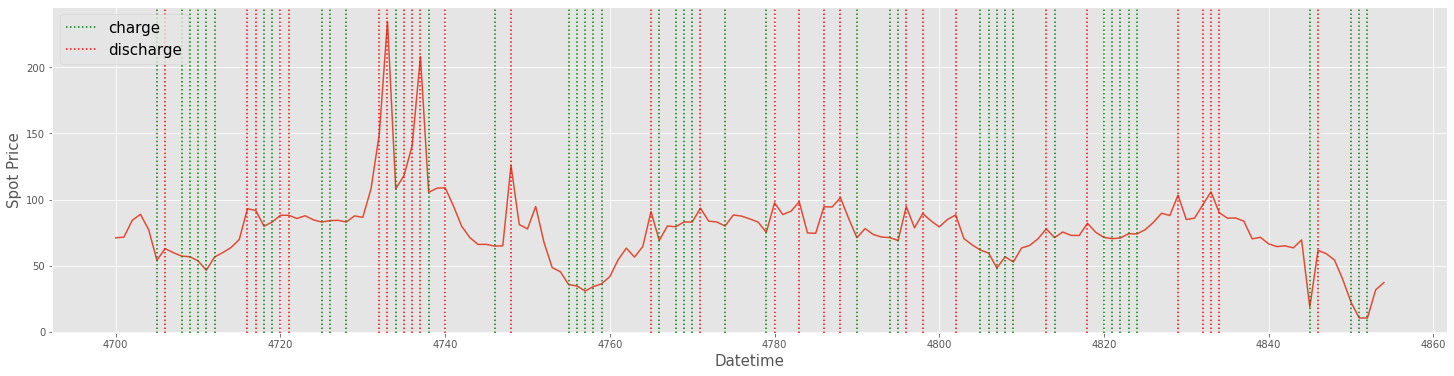

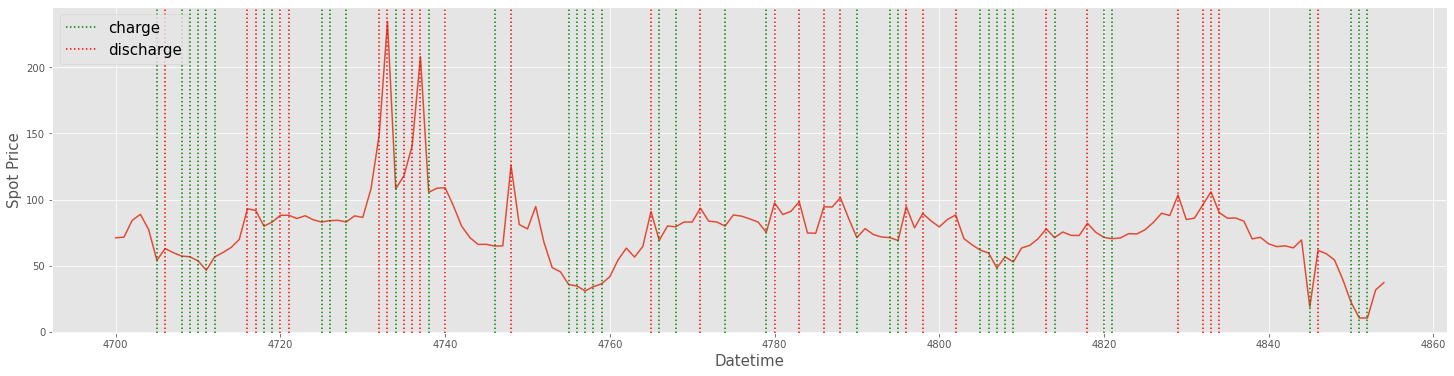

In [4]:
start = 4700
end = 4855
plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)
df.forecast = filter_forecast(df.spot_price, df.forecast)
df = compute_algo(df)
plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)
# df.forecast = optimize_combination(df.spot_price, df.forecast)
# df = compute_algo(df)
# plot_actions(df.spot_price, df.raw_power, start=start, end=end)
# print('Total market revenue:', df.market_revenue.sum())

In [6]:
df_train.head()

,spot_price,period,year,forecast,raw_power,market_dispatch,market_revenue,closing_capacity,opening_capacity
0,92.46,2.00,2018.00,0.00,0.00,0.00,0.00,0.00,0.00
1,87.62,3.00,2018.00,0.00,0.00,0.00,0.00,0.00,0.00
2,73.08,4.00,2018.00,0.00,0.00,0.00,0.00,0.00,0.00
3,70.18,5.00,2018.00,0.00,0.00,0.00,0.00,0.00,0.00
4,67.43,6.00,2018.00,0.00,0.00,0.00,0.00,0.00,0.00
5,66.31,7.00,2018.00,0.00,0.00,0.00,0.00,0.00,0.00
6,67.72,8.00,2018.00,0.00,0.00,0.00,0.00,0.00,0.00
7,65.50,9.00,2018.00,0.00,0.00,0.00,0.00,0.00,0.00
8,64.50,10.00,2018.00,-1.00,-300.00,-150.00,-9763.00,135.00,0.00
9,65.41,11.00,2018.00,0.00,0.00,0.00,0.00,135.00,135.00


In [9]:
def filter_3(df):
    """
    Notes: Compute forecast using algorithm 3 raw power function
    ----------
    Parameters
    ----------
    df    : dataframe with spot_price & forecast columns
    
    Returns
    -------
    df    : dataframe
    """
#     df = pd.DataFrame({'spot_price': spot_price, 'forecast': forecast, 'org_index': org_index}).reset_index(drop = True)
    

    # get column index
    columns = list(df.columns)
    spot_price_idx = columns.index('spot_price')
    forecast_idx = columns.index('forecast')
    index_idx = columns.index('org_index')

    arr = df.to_numpy()
    i =1
    cur_df = [[0, arr[0][spot_price_idx]]]
   
    while i < len(arr):
        
        arr_curr = arr[i]
        spot_price = arr_curr[spot_price_idx]
        
        if arr_curr[index_idx] == (arr[i-1][index_idx] + 1):
            cur_df.append([i, spot_price])
            i = i + 1
        
        # stop when not continue
        else:
            max_idx = np.argmax([item[1] for item in cur_df])
            cur_df = cur_df[0:max_idx+1]
           
            min_idx = np.argmin([item[1] for item in cur_df])
            min_price  = cur_df[min_idx][1]
            max_price = cur_df[max_idx][1]
            dischar_idx = cur_df[max_idx][0]
            arr[dischar_idx][forecast_idx] = 1
            # choose charge price
            if max_price > min_price*1.27:
                char_idx = cur_df[min_idx][0]
                arr[char_idx][forecast_idx] = -1
                
            # reset cur_df
            cur_df = [[i, arr[i][spot_price_idx]]]
            i = i+1
    
    df[:] = arr
    forecast = df.forecast
    return forecast.to_numpy()


In [22]:
# Algo Test Tom 2 (with forecast filtered & combination optimization)
df_train = vic.copy(deep=False)[['spot_price', 'period', 'year']]
df_train['forecast'] = calc_forecast_tom_2(df_train.spot_price)
df_train['forecast'] = filter_forecast(df_train.spot_price, df_train.forecast)
df_train['forecast'] = optimize_combination(df_train.spot_price, df_train.forecast)
df_train = compute_algo(df_train)

# more filter
space = df_train.loc[(df_train['forecast'] == 0) & (df_train['closing_capacity'] == 0)].iloc[:, [0,3]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_train.loc[idx, 'forecast'] = filter_3(space)

space = df_train.loc[(df_train['forecast'] == 0) & (df_train['closing_capacity'] == 0)].iloc[:, [0,3]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_train.loc[idx, 'forecast'] = filter_3(space)

space = df_train.loc[(df_train['forecast'] == 0) & (df_train['closing_capacity'] == 0)].iloc[:, [0,3]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_train.loc[idx, 'forecast'] = filter_3(space)

# end

df_train = compute_algo(df_train)
print('=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===')
print(df_train.groupby('year').market_revenue.sum())
print('Total Revenue:', df_train.market_revenue.sum())
df_test = vic_cv.copy(deep=False)[['spot_price', 'period', 'year']]
df_test['forecast'] = calc_forecast_tom_2(df_test.spot_price)
df_test['forecast'] = filter_forecast(df_test.spot_price, df_test.forecast)
df_test['forecast'] = optimize_combination(df_test.spot_price, df_test.forecast)
df_test = compute_algo(df_test)

space = df_test.loc[(df_test['forecast'] == 0) & (df_test['closing_capacity'] == 0)].iloc[:, [0,3]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_test.loc[idx, 'forecast'] = filter_3(space)

space = df_test.loc[(df_test['forecast'] == 0) & (df_test['closing_capacity'] == 0)].iloc[:, [0,3]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_test.loc[idx, 'forecast'] = filter_3(space)

space = df_test.loc[(df_test['forecast'] == 0) & (df_test['closing_capacity'] == 0)].iloc[:, [0,3]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_test.loc[idx, 'forecast'] = filter_3(space)

df_test = compute_algo(df_test)
print('2021 Revenue:', df_test.market_revenue.sum(), '\n')
print("total:", df_test.market_revenue.sum()+df_train.market_revenue.sum())

=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===
year
2018.00   32430244.00
2019.00   43449290.00
2020.00   29714455.00
Name: market_revenue, dtype: float64
Total Revenue: 105593989.0
2021 Revenue: 17341856.0 

total: 122935845.0
